##인공지능개론 Project Model 2 : EMNIST by merge Classification

In [344]:
import time
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
import matplotlib.pyplot as plt
import random

In [345]:
SEED = 5882
random.seed(SEED) # python
torch.manual_seed(SEED) # torch
torch.cuda.manual_seed(SEED) # cuda

> Define Hyper Parameters

In [346]:
# device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# hyper - parameters
num_classes = 47 # 고정값 (EMNIST(bymerge))
input_size = 28 # 고정값
sequence_length = 28 # 고정값
num_epochs = 7
learning_rate = 0.001
batch_size = 256
hidden_dim = 256
num_layers = 3
drop_percent = 0.2

>  Load Data and Define Data Loader : EMNIST by merge

In [347]:
train_data = torchvision.datasets.EMNIST(root='./EMNIST',
                                         split='bymerge',
                                         train=True,
                                         download=True,
                                         transform=transforms.ToTensor())
test_data = torchvision.datasets.EMNIST(root='./EMNIST',
                                         split='bymerge',
                                         train=False,
                                         download=True,
                                         transform=transforms.ToTensor())

In [348]:
train_loader = torch.utils.data.DataLoader(train_data,
                                     batch_size=batch_size,
                                     shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data,
                                     batch_size=batch_size,
                                     shuffle=False)

>  Build Model for EMNIST Classification

In [349]:
class Model2(nn.Module):
  def __init__(self, input_size, hidden_dim, num_layers, num_classes, drop_percent):
    super(Model2, self).__init__()
    self.hidden_size = hidden_dim
    self.num_layers = num_layers
    self.drop_percent = drop_percent

    self.dropout = nn.Dropout(drop_percent)
    self.fc = nn.Linear(hidden_dim, num_classes)

    self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
    c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

    out, _ = self.lstm(x, (h0, c0))
    out = self.dropout(out)
    out = self.fc(out[:,-1,:])

    return out

In [350]:
model = Model2(input_size, hidden_dim, num_layers, num_classes, drop_percent).to(device)

> Set Loss Function and Optimizer

In [351]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

> Begin Training

In [352]:
best_epoch = 0
best_loss = float('inf')
total_step = len(train_loader)
loss_list = []

In [353]:
start = time.time()
for epoch in range(num_epochs):
  for i, (image, label) in enumerate(train_loader):
    image = image.reshape(-1, sequence_length, input_size).to(device)
    label = label.to(device)

    # Forward
    output = model(image)
    loss = criterion(output, label)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_list.append(loss.item())

    if loss.item() < best_loss:
      best_loss = loss.item()
      torch.save(model.state_dict(), "20181202_model2.pth")

    if (i+1) % 1000 == 0:
      print("Epoch [{}/{}], Step[{}/{}], Loss:{:.4f}".format(epoch+1, num_epochs, i+1, total_step, loss.item()))

end = time.time()
print("\n>> Train takes {:.2f} minutes".format((end-start)/60))

Epoch [1/7], Step[1000/2727], Loss:0.4990
Epoch [1/7], Step[2000/2727], Loss:0.3504
Epoch [2/7], Step[1000/2727], Loss:0.3609
Epoch [2/7], Step[2000/2727], Loss:0.3041
Epoch [3/7], Step[1000/2727], Loss:0.3362
Epoch [3/7], Step[2000/2727], Loss:0.1997
Epoch [4/7], Step[1000/2727], Loss:0.2417
Epoch [4/7], Step[2000/2727], Loss:0.2449
Epoch [5/7], Step[1000/2727], Loss:0.2363
Epoch [5/7], Step[2000/2727], Loss:0.3308
Epoch [6/7], Step[1000/2727], Loss:0.2128
Epoch [6/7], Step[2000/2727], Loss:0.2347
Epoch [7/7], Step[1000/2727], Loss:0.1941
Epoch [7/7], Step[2000/2727], Loss:0.2678

>> Train takes 13.90 minutes


> Show the Loss Graph of Training

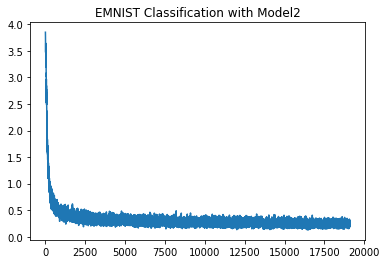

In [356]:
plt.plot(loss_list)
plt.title("EMNIST Classification with Model2")
plt.show()

> Test Model2 and Check Accuracy

In [357]:
model.load_state_dict(torch.load('./20181202_model2.pth'))

with torch.no_grad():
  correct = 0
  
  for image, label in test_loader:
    image = image.reshape(-1, sequence_length, input_size).to(device)
    label = label.to(device)
    output = model(image)
    _ , pred = torch.max(output.data, 1)
    correct += (pred == label).sum().item()

  print("Accuracy of Model1 on the {} test images: {}%".format(len(test_loader)*batch_size, 100 * correct / (len(test_loader) * batch_size)))

Accuracy of Model1 on the 116480 test images: 90.07383241758242%
